# Semi-invertible autoencoder

In [1]:
import numpy as np
import logging
import sys
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

%matplotlib inline
sys.path.append("../")

import torch
from torchvision.datasets import MNIST
from torchvision import transforms

from aef.models.autoencoding_flow import TwoStepAutoencodingFlow
from aef.trainer import AutoencodingFlowTrainer
from aef.losses import nll, mse

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)


## Data

In [2]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist = MNIST('./data', download=True, transform=img_transform)

## Train autoencoder

In [3]:
ae = TwoStepAutoencodingFlow(data_dim=28*28, latent_dim=16, steps_inner=2, steps_outer=2)

16:35 aef.models.autoencod INFO    Created autoencoding flow with 7852832 trainable parameters


In [4]:
trainer = AutoencodingFlowTrainer(ae, output_filename="../figures/training/aef/aef_phase1")
trainer.train(
    dataset=mnist,
    loss_functions=[mse],
    loss_labels=["MSE"],
    loss_weights=[1.],
    batch_size=256,
    epochs=5,
    verbose="all",
    initial_lr=1.e-3,
    final_lr=1.e-4,
)

16:52 aef.trainer          INFO    Epoch   1: train loss  0.15710 (MSE:  0.157)
16:52 aef.trainer          INFO               val. loss   0.08662 (MSE:  0.087)
17:02 aef.trainer          INFO    Epoch   2: train loss  0.07421 (MSE:  0.074)
17:02 aef.trainer          INFO               val. loss   0.06836 (MSE:  0.068)
17:13 aef.trainer          INFO    Epoch   3: train loss  0.06264 (MSE:  0.063)
17:13 aef.trainer          INFO               val. loss   0.06090 (MSE:  0.061)
17:23 aef.trainer          INFO    Epoch   4: train loss  0.05736 (MSE:  0.057)
17:23 aef.trainer          INFO               val. loss   0.05647 (MSE:  0.056)
17:33 aef.trainer          INFO    Epoch   5: train loss  0.05434 (MSE:  0.054)
17:33 aef.trainer          INFO               val. loss   0.05412 (MSE:  0.054)
17:33 aef.trainer          INFO    Early stopping did not improve performance


(array([0.15709885, 0.07420711, 0.0626389 , 0.05735787, 0.05434455]),
 array([0.08661989, 0.06835877, 0.0609037 , 0.05647002, 0.05412115]))

In [5]:
trainer.train(
    dataset=mnist,
    loss_functions=[nll],
    loss_labels=["NLL"],
    loss_weights=[1.],
    batch_size=256,
    epochs=5,
    verbose="all",
    initial_lr=1.e-3,
    final_lr=1.e-4,
    parameters=ae.outer_transformation.parameters()
)

AttributeError: 'TwoStepAutoencodingFlow' object has no attribute 'outer_transformation'

## Visualize latent space

In [6]:
n = 1000

x = torch.cat([mnist[i][0].unsqueeze(0) for i in range(n)], dim=0)
y = np.asarray([mnist[i][1] for i in range(n)])

x = x.view(x.size(0), -1)
x.to(torch.device("cpu"))
x_out, _, u = ae(x)

x = x.detach().numpy().reshape(-1, 28, 28)
x_out = x_out.detach().numpy().reshape(-1, 28, 28)
u = u.detach().numpy().reshape(x_out.shape[0], -1)
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(u)

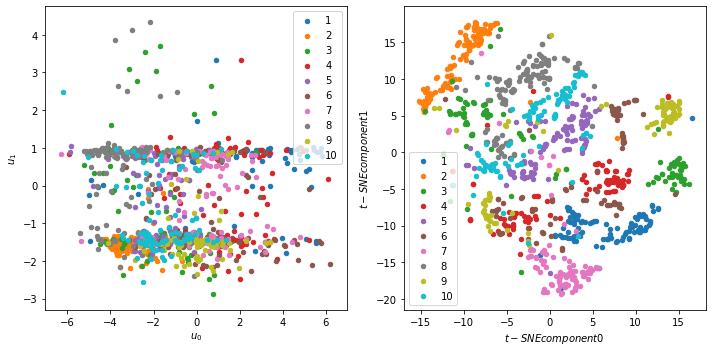

In [7]:
fig = plt.figure(figsize=(10,5))

ax = plt.subplot(1,2,1)
for i in range(10):
    plt.scatter(u[y==i][:,0], u[y==i][:,1], c="C{}".format(i), s=20., label="{}".format(i+1))
plt.legend()
plt.xlabel(r"$u_0$")
plt.ylabel(r"$u_1$")
    
ax = plt.subplot(1,2,2)
for i in range(10):
    plt.scatter(tsne[y==i][:,0], tsne[y==i][:,1], c="C{}".format(i), s=20., label="{}".format(i+1))
plt.legend()
plt.xlabel(r"$t-SNE component 0$")
plt.ylabel(r"$t-SNE component 1$")

plt.tight_layout()
plt.savefig("../figures/mnist_latent.pdf")


## Visualize reconstruction

In [8]:
x = torch.cat([mnist[i][0] for i in range(1000)], dim=0)
x = x.view(x.size(0), -1)
y = np.asarray([mnist[i][1] for i in range(1000)])

In [9]:
x.size()

torch.Size([1000, 784])

In [10]:
h = ae.encode(x)
x_out = ae.decode(h)

In [18]:
h = h.detach().numpy()
x = x.detach().numpy()
x_out = x_out.detach().numpy()

In [19]:
np.min(x), np.max(x)

(-1.0, 1.0)

In [20]:
np.min(x_out), np.max(x_out)

(-1.94815, 1.9858634)

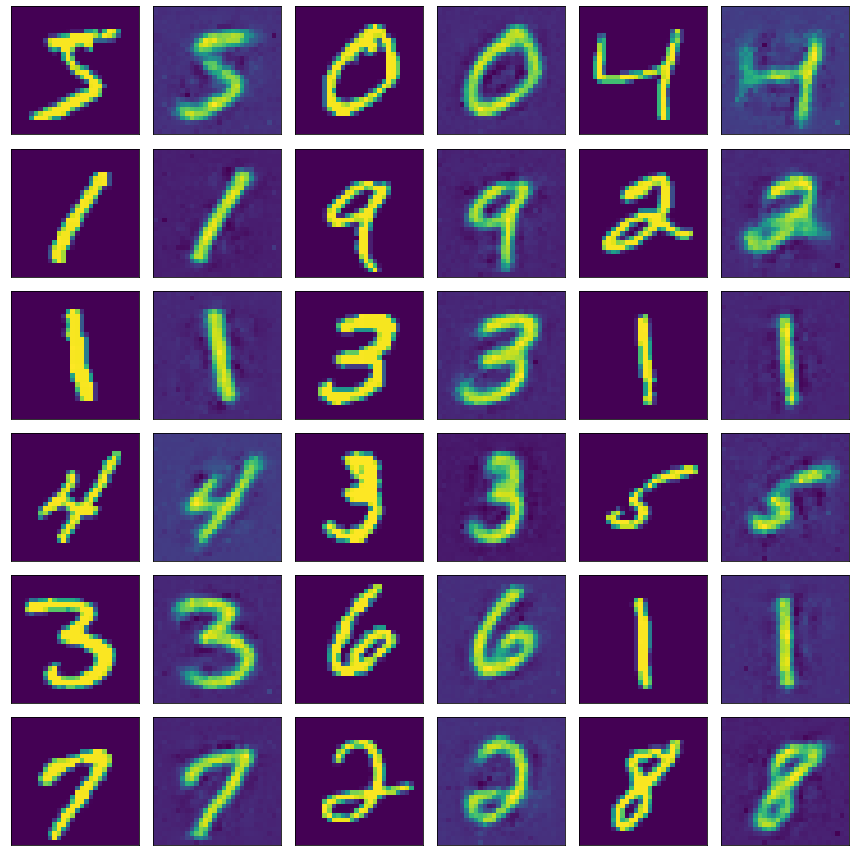

In [11]:
fig = plt.figure(figsize=(12,12))

for i in range(18):
    ax = plt.subplot(6, 6, 2*i + 1)
    plt.imshow(x[i].reshape((28,28)), cmin=-1.1, cmax=1.1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(6, 6, 2*i + 2)
    plt.imshow(x_out[i].reshape((28,28)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
plt.tight_layout()
plt.savefig("../figures/reconstruction.pdf")
